In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from matplotlib.image import imread
import tensorflow as tf
import keras.utils as image

In [17]:
breast_img = glob.glob('D:/Dowload/breast-cancer/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

D:/Dowload/breast-cancer/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
D:/Dowload/breast-cancer/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
D:/Dowload/breast-cancer/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png


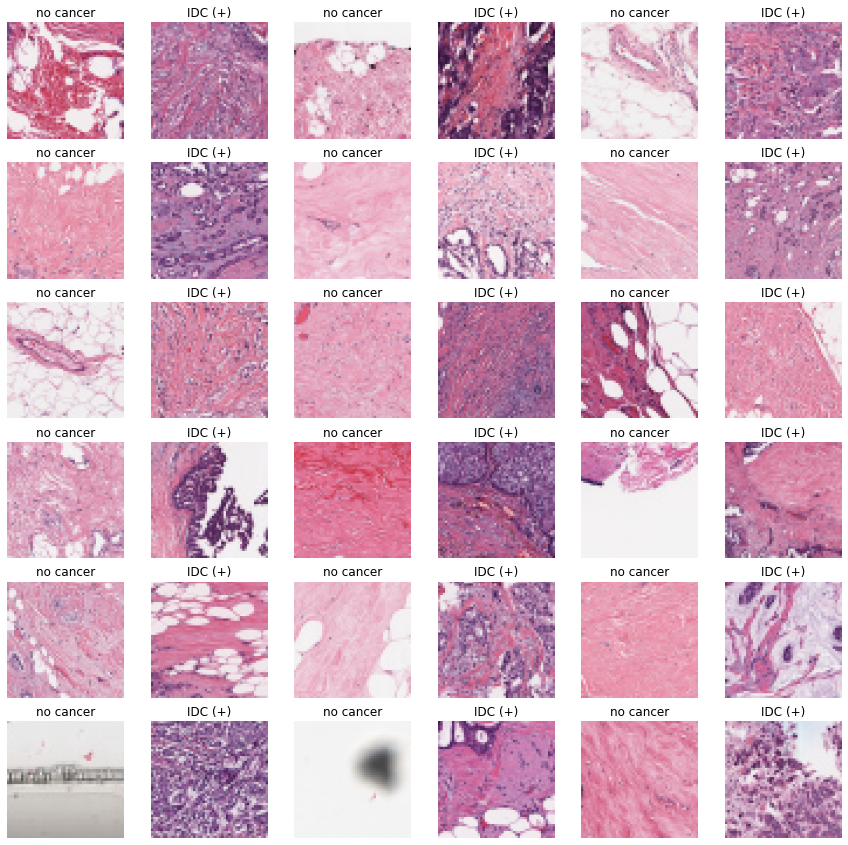

In [18]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [19]:
non_img_arr = []
can_img_arr = []
NewN_IDC=N_IDC[:78786]

for img in NewN_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [20]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [21]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 157572
Number of IDC(-) Images: 133460
Number of IDC(+) Images: 24112
Image shape (Width, Height, Channels): (50, 50, 3)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (110300, 50, 50, 3)
Testing Data Shape: (47272, 50, 50, 3)


In [23]:
X_train = X_train[0:50000] 
Y_train = Y_train[0:50000] 
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000] 

In [24]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [29]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, add, Flatten, Dense

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)
    
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)
    
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(50, 50, 3), classes=1000):
    img_input = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = AveragePooling2D((7, 7), name='avg_pool',padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes))(x)
    
    model = Model(img_input, x, name='resnet50')
    return model


model = ResNet50(input_shape=(50, 50, 3), classes=2)


model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 25, 25, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 activation_98 (Activation)     (None, 25, 25, 64)   0           ['bn_conv1[0][0]']               
                                                                                           

 ion)                                                                                             
                                                                                                  
 add_34 (Add)                   (None, 12, 12, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_104[0][0]']         
                                                                                                  
 activation_107 (Activation)    (None, 12, 12, 256)  0           ['add_34[0][0]']                 
                                                                                                  
 res3a_branch2a (Conv2D)        (None, 6, 6, 128)    32896       ['activation_107[0][0]']         
                                                                                                  
 bn3a_branch2a (BatchNormalizat  (None, 6, 6, 128)   512         ['res3a_branch2a[0][0]']         
 ion)     

                                                                                                  
 res3d_branch2a (Conv2D)        (None, 6, 6, 128)    65664       ['activation_116[0][0]']         
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 6, 6, 128)   512         ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_117 (Activation)    (None, 6, 6, 128)    0           ['bn3d_branch2a[0][0]']          
                                                                                                  
 res3d_branch2b (Conv2D)        (None, 6, 6, 128)    147584      ['activation_117[0][0]']         
                                                                                                  
 bn3d_bran

 activation_126 (Activation)    (None, 3, 3, 256)    0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv2D)        (None, 3, 3, 256)    590080      ['activation_126[0][0]']         
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 3, 3, 256)   1024        ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_127 (Activation)    (None, 3, 3, 256)    0           ['bn4c_branch2b[0][0]']          
                                                                                                  
 res4c_branch2c (Conv2D)        (None, 3, 3, 1024)   263168      ['activation_127[0][0]']         
          

 bn4f_branch2c (BatchNormalizat  (None, 3, 3, 1024)  4096        ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_44 (Add)                   (None, 3, 3, 1024)   0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_134[0][0]']         
                                                                                                  
 activation_137 (Activation)    (None, 3, 3, 1024)   0           ['add_44[0][0]']                 
                                                                                                  
 res5a_branch2a (Conv2D)        (None, 2, 2, 512)    524800      ['activation_137[0][0]']         
                                                                                                  
 bn5a_bran

 activation_146 (Activation)    (None, 2, 2, 2048)   0           ['add_47[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 1, 1, 2048)   0           ['activation_146[0][0]']         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 fc2 (Dense)                    (None, 2)            4098        ['flatten_1[0][0]']              
                                                                                                  
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(96, (11, 11), kernel_initializer='he_uniform', strides=(4, 4), activation='relu', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5),kernel_initializer='he_uniform', strides=(1, 1), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3),kernel_initializer='he_uniform', strides=(1, 1), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(384, (1, 1),kernel_initializer='he_uniform', strides=(1, 1), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (1, 1),kernel_initializer='he_uniform', strides=(1, 1), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

In [30]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
history=model.fit(X_train,Y_train, validation_data=(X_test, Y_test),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 2987s 2s/step - loss: 0.4515 - accuracy: 0.8293 - val_loss: 0.4108 - val_accuracy: 0.8438
Epoch 2/10
1563/1563 [==============================] - 2894s 2s/step - loss: 0.3877 - accuracy: 0.8496 - val_loss: 0.3910 - val_accuracy: 0.8431
Epoch 3/10
1563/1563 [==============================] - 2868s 2s/step - loss: 0.3709 - accuracy: 0.8519 - val_loss: 0.3732 - val_accuracy: 0.8486
Epoch 4/10
1563/1563 [==============================] - 2540s 2s/step - loss: 0.3616 - accuracy: 0.8541 - val_loss: 0.3639 - val_accuracy: 0.8530
Epoch 5/10
1563/1563 [==============================] - 2609s 2s/step - loss: 0.3514 - accuracy: 0.8571 - val_loss: 0.3583 - val_accuracy: 0.8523
Epoch 6/10
1563/1563 [==============================] - 2703s 2s/step - loss: 0.3467 - accuracy: 0.8598 - val_loss: 0.3534 - val_accuracy: 0.8555
Epoch 7/10
1563/1563 [==============================] - 2773s 2s/step - loss: 0.3417 - accuracy: 0.8608 - val_loss: 0.3476 -

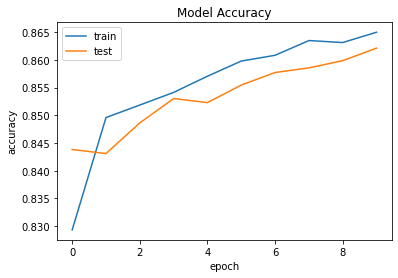

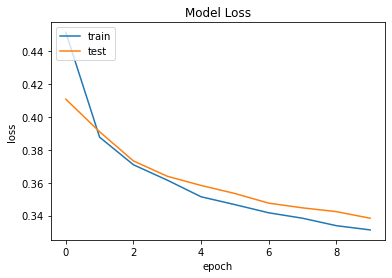

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
model.evaluate(X_test,Y_test)

938/938 [==============================] - 122s 130ms/step - loss: 0.3384 - accuracy: 0.8621


[0.33839231729507446, 0.8621333241462708]